# Inicio

In [51]:
import pandas as pd
import numpy as np
import re
import os
import json
#import boto3
from datetime import date
from matplotlib import pyplot as plt
import pickle

import warnings
warnings.filterwarnings("ignore")

# Importar archivo

In [2]:
green_df = pd.read_csv("green_trips_day.csv")
green_df.drop(columns=["Unnamed: 0", "barrio_destino"], inplace=True)
green_df.dia = pd.to_datetime(green_df.dia).dt.date
mask = green_df["barrio_abordaje"].apply(lambda x: x not in ["Unknown", "EWR"])
green_df = green_df[mask]
green_df.head()

,barrio_abordaje,dia,cant_registros,sum_total,sum_distancia,prom_total
0,Bronx,2022-01-01,36,505.60,92.11,14.044444
1,Bronx,2022-01-02,34,583.59,82.70,17.164412
2,Bronx,2022-01-03,54,898.07,108.46,16.630926
3,Bronx,2022-01-04,45,720.11,85.53,16.002444
4,Bronx,2022-01-05,47,675.54,110.59,14.373191


<p>Se eliminan las columnas no utilizadas y los registros con valores no utilizados (aquellos en donde "barrio_abordaje" tiene un valor diferente a los 5 barrios a estudiar)

# Entrenamiento de modelo para taxis verdes
## Creación de tabla pivote, autocorrelación y autocorrelación parcial

<p>Para el entrenamiento de los modelos, se realizará una tabla pivote, que tendrá como columnas las diferentes medidas a estudiar (cantidad de registros, suma de distancia, suma de costo total, promedio de costo total) para cada uno de los barrios (Bronx, Brooklyn, Manhattan, Queens, Staten Island), y los índices serán los días. En el caso de las columnas de promedio de total, se realizará el cálculo sobre los valores de las columnas de suma de total y cantidad.

In [3]:
green_df_pivot = green_df.pivot_table(index="dia", columns="barrio_abordaje", values=["cant_registros", "sum_distancia", "sum_total"], fill_value=0, aggfunc="sum")
green_df_pivot.columns = ["cant_registros_bronx", "cant_registros_brooklyn", "cant_registros_manhattan", "cant_registros_queens", "cant_registros_island",\
                            "sum_distancia_bronx", "sum_distancia_brooklyn", "sum_distancia_manhattan", "sum_distancia_queens", "sum_distancia_island",\
                            "sum_total_bronx", "sum_total_brooklyn", "sum_total_manhattan", "sum_total_queens", "sum_total_island"]
for col in ["bronx", "brooklyn", "manhattan", "queens", "island"]:
    green_df_pivot[f"prom_total_{col}"] = green_df_pivot[f"sum_total_{col}"]/green_df_pivot[f"cant_registros_{col}"]
    green_df_pivot[f"prom_total_{col}"].fillna(0, inplace=True)
    green_df_pivot[f"cant_registros_{col}"] = green_df_pivot[f"cant_registros_{col}"].astype("float64")
green_df_pivot

,cant_registros_bronx,cant_registros_brooklyn,cant_registros_manhattan,cant_registros_queens,cant_registros_island,sum_distancia_bronx,sum_distancia_brooklyn,sum_distancia_manhattan,sum_distancia_queens,sum_distancia_island,sum_total_bronx,sum_total_brooklyn,sum_total_manhattan,sum_total_queens,sum_total_island,prom_total_bronx,prom_total_brooklyn,prom_total_manhattan,prom_total_queens,prom_total_island
dia,,,,,,,,,,,,,,,,,,,,
2022-01-01,64.0,294.0,585.0,312.0,0.0,238.14,1333.38,1635.64,1058.50,0.00,1222.41,7820.59,8815.17,6322.24,0.0,19.100156,26.600646,15.068667,20.263590,0.0
2022-01-02,54.0,320.0,775.0,318.0,1.0,164.79,1133.99,2029.29,1081.88,9.63,1228.54,6808.78,11523.57,6170.84,50.1,22.750741,21.277437,14.869123,19.405157,50.1
2022-01-03,79.0,401.0,1324.0,489.0,0.0,206.71,1228.74,3302.72,1497.00,0.00,1701.54,8202.06,19437.35,8209.94,0.0,21.538481,20.454015,14.680778,16.789243,0.0
2022-01-04,65.0,370.0,1237.0,469.0,0.0,154.94,1193.91,3169.75,1500.47,0.00,1318.13,8088.00,19142.74,8661.85,0.0,20.278923,21.859459,15.475133,18.468763,0.0
2022-01-05,81.0,369.0,1309.0,479.0,0.0,229.30,1143.94,3372.44,1463.16,0.00,2103.96,7851.64,19937.15,8736.93,0.0,25.974815,21.278157,15.230825,18.239937,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-25,11.0,291.0,736.0,295.0,0.0,56.25,970.73,1777.11,958.33,0.00,391.01,7609.48,14798.98,7519.41,0.0,35.546364,26.149416,20.107310,25.489525,0.0
2024-02-26,20.0,214.0,1217.0,407.0,0.0,55.27,635.70,2870.76,1159.18,0.00,476.07,5640.91,26092.25,9546.83,0.0,23.803500,26.359393,21.439811,23.456585,0.0
2024-02-27,28.0,259.0,1212.0,506.0,0.0,73.29,753.61,2824.32,1196.31,0.00,895.91,6717.35,25607.65,10598.03,0.0,31.996786,25.935714,21.128424,20.944723,0.0


<p>Para el modelo, se plantea utilizar la librería skforecast y el modelo RandomForest para adaptar las series temporales múltiples, por las razones expuestas anteriormente: optimización de parámetros con grid, entrenamiento en multiserie, robustez y eficiencia del modelo de bosque. Además, se muestran los diagramas ACF y PACF, entrenando el modelo sobre 5, 7, 8, 9, 11 y 14 lags.

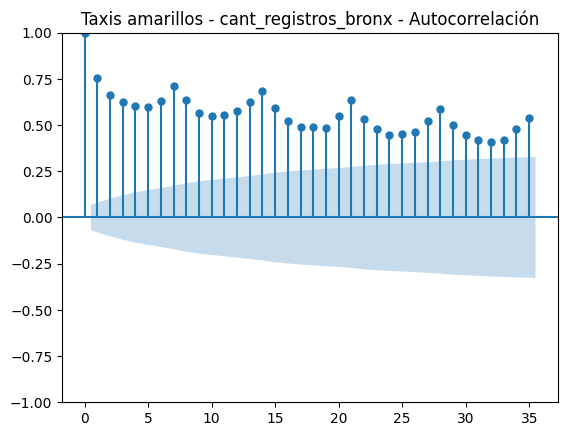

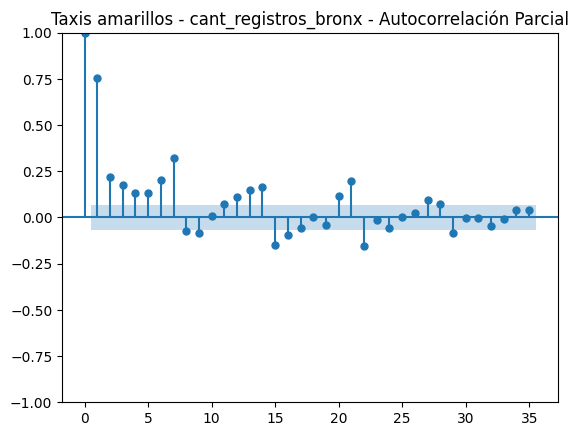

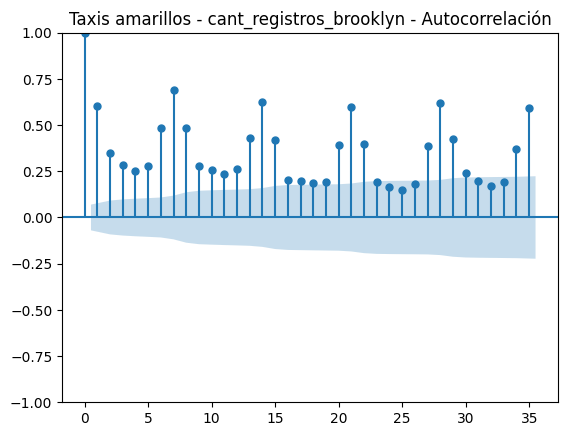

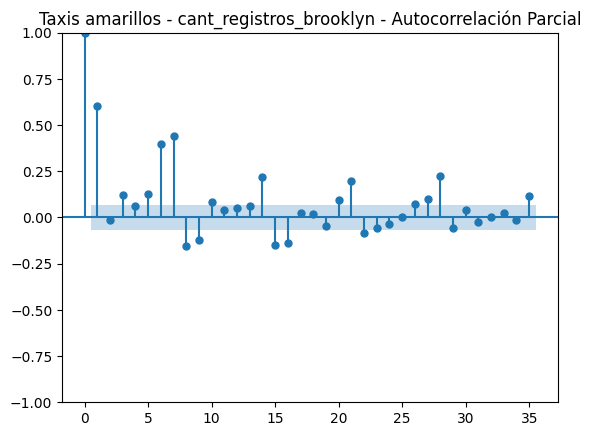

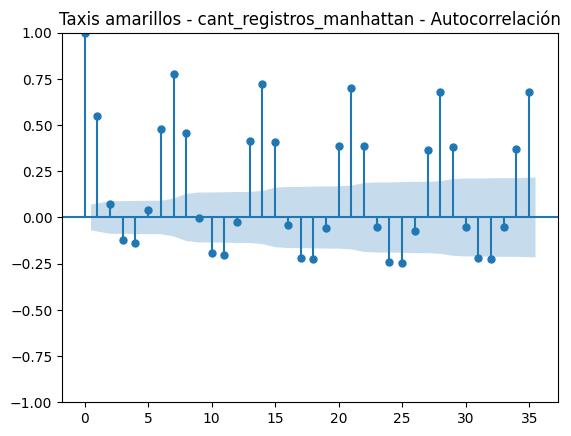

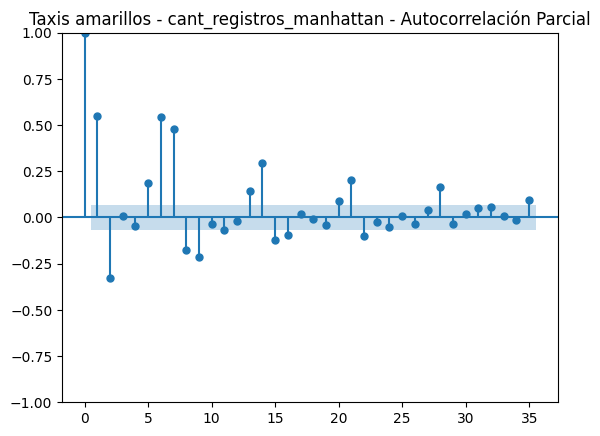

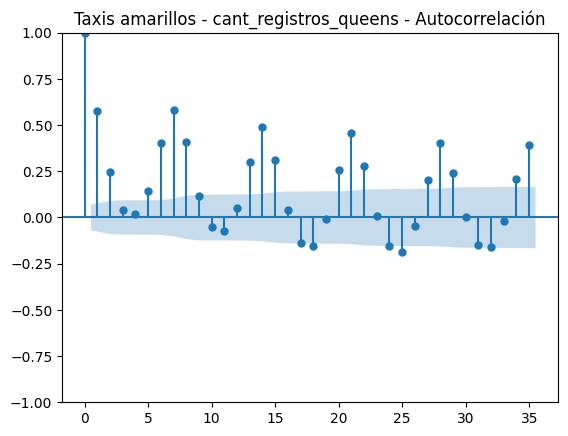

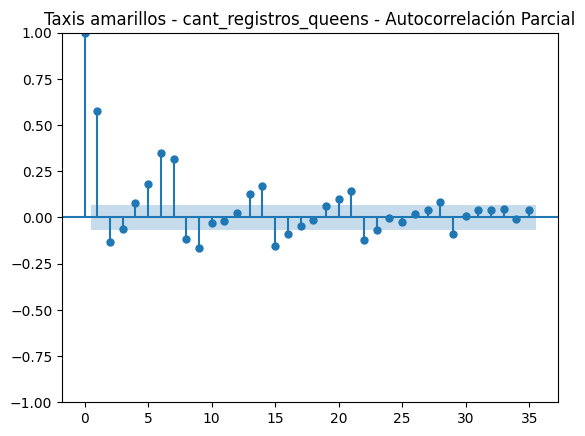

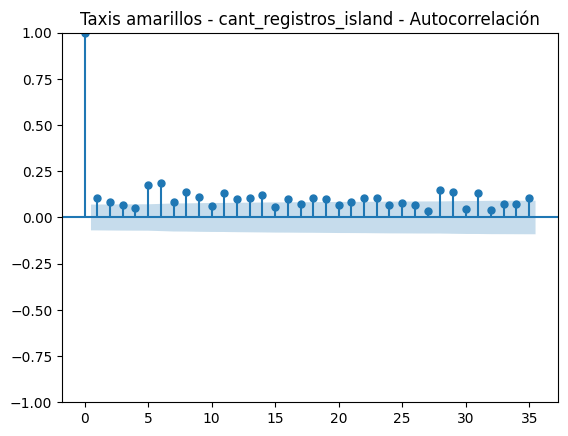

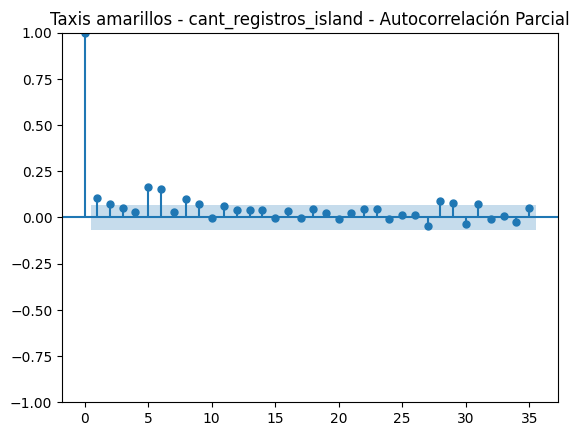

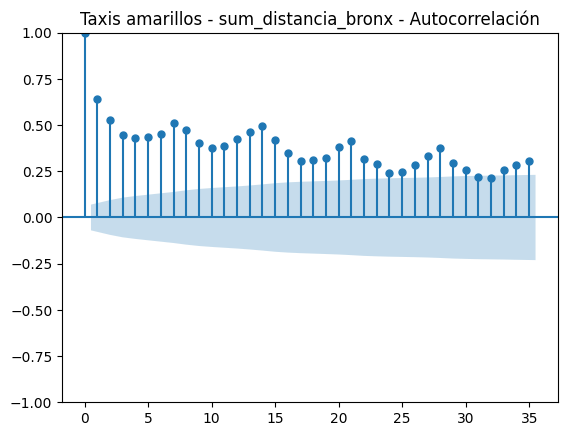

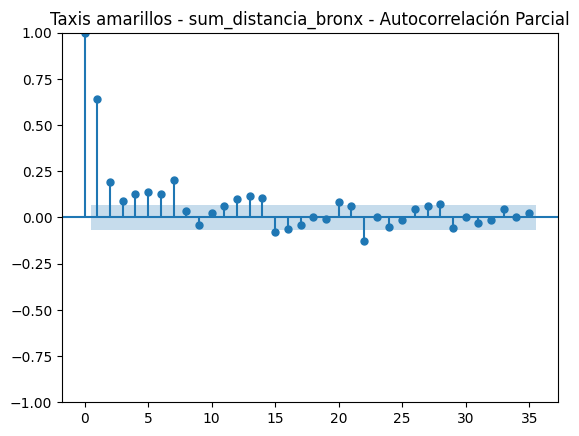

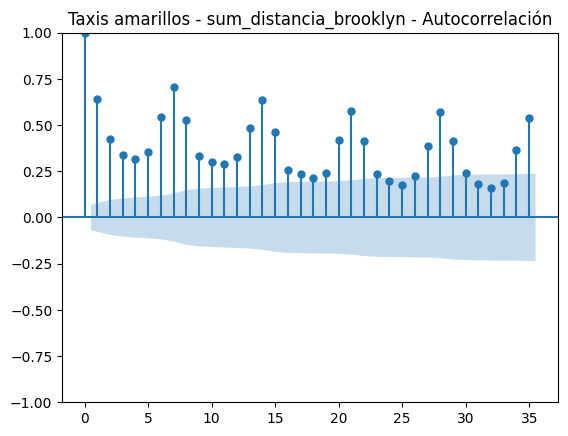

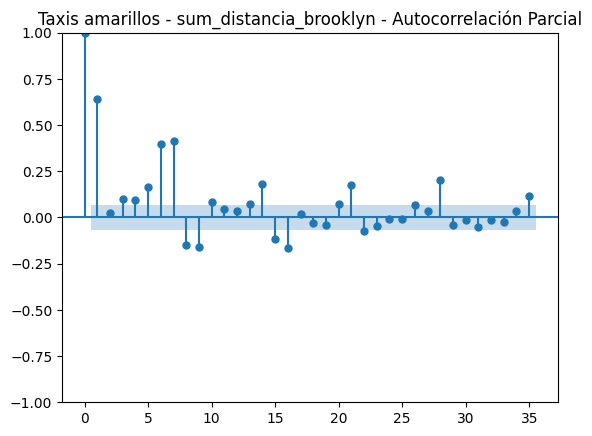

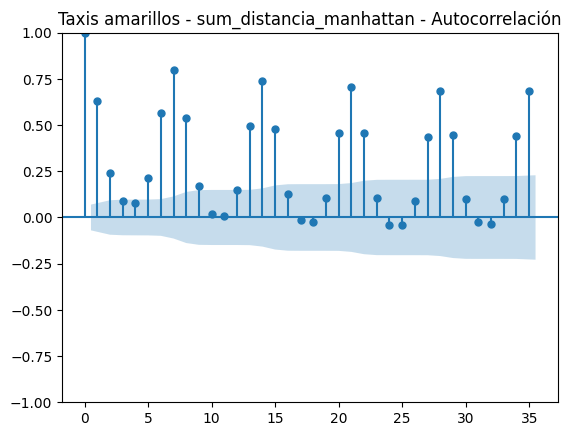

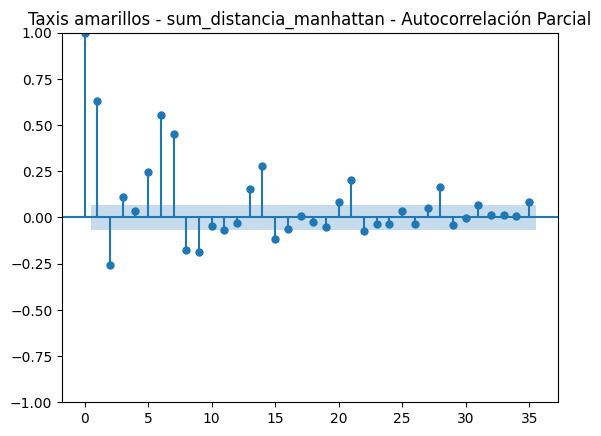

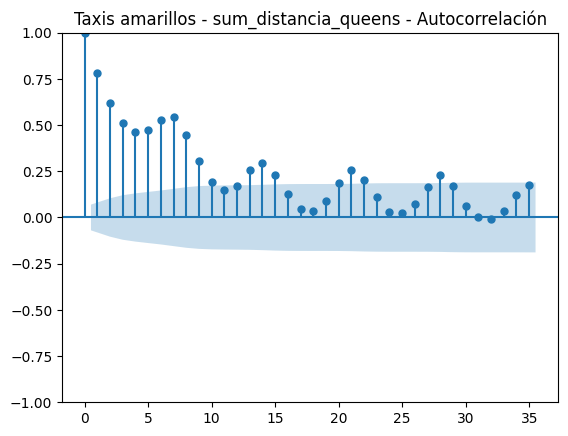

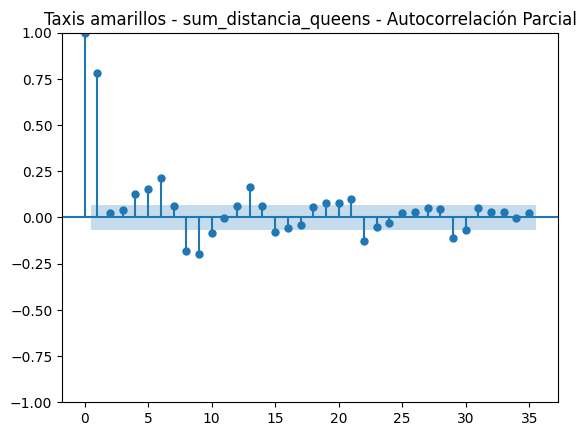

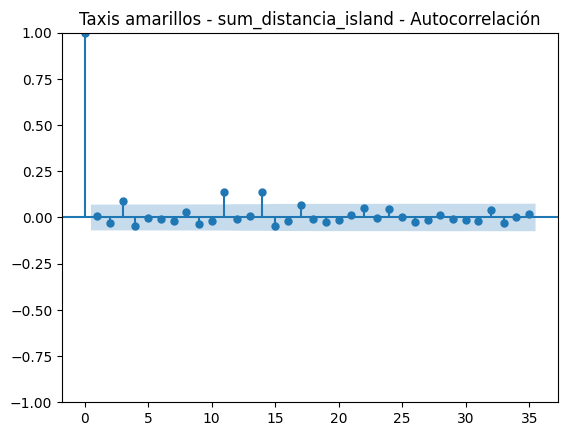

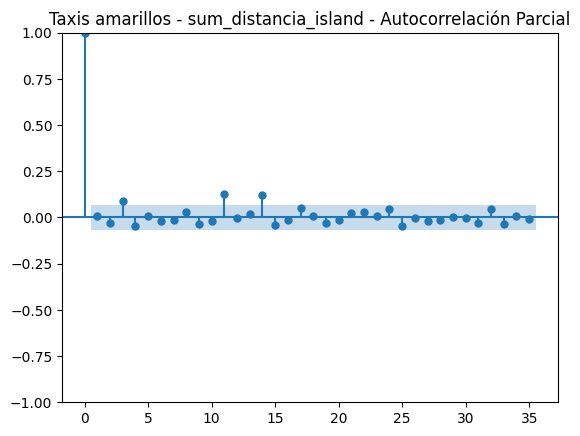

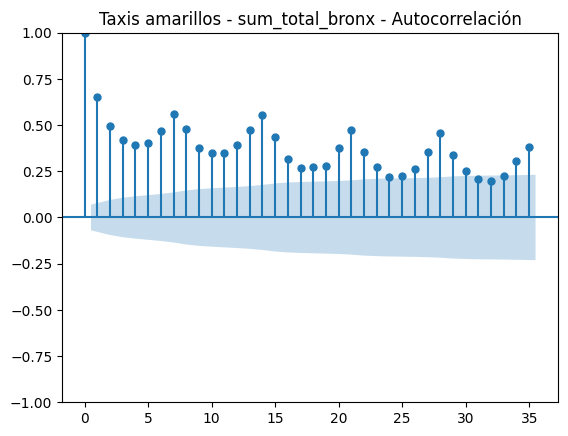

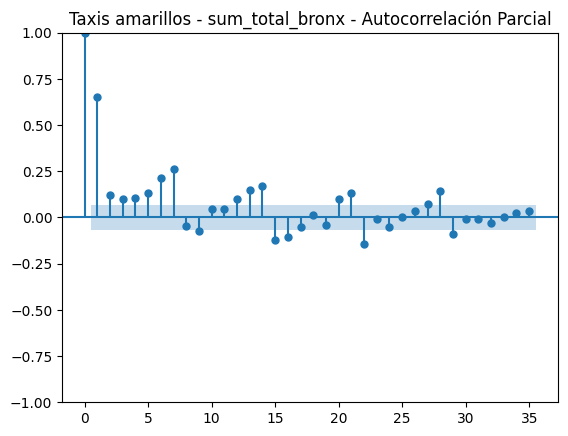

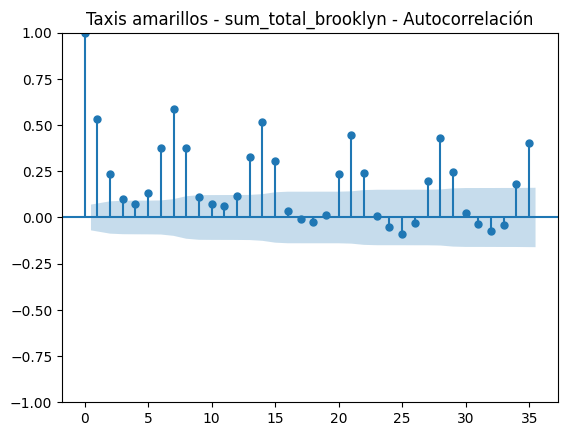

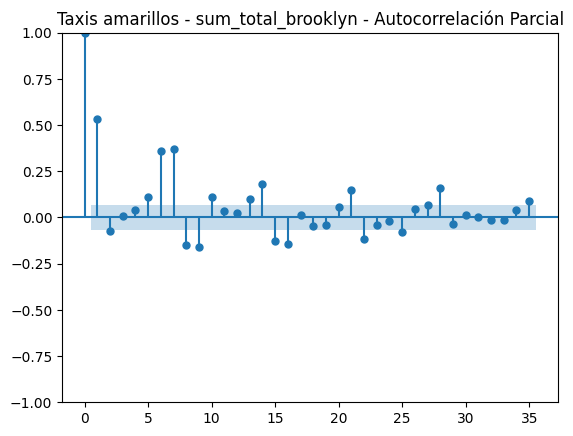

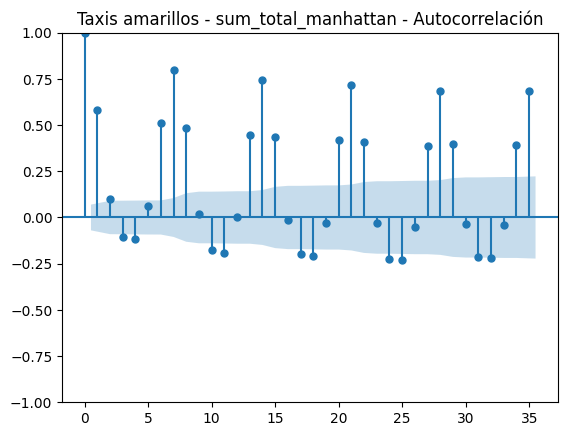

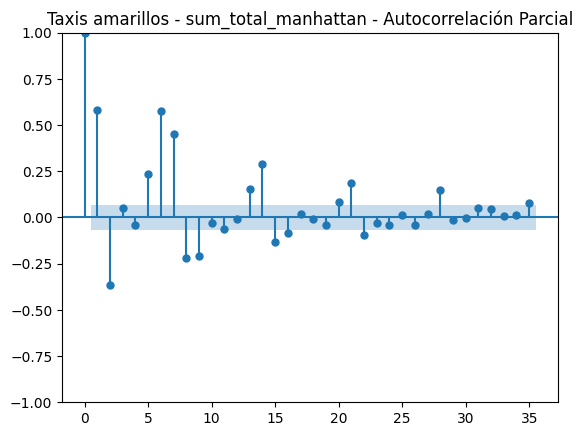

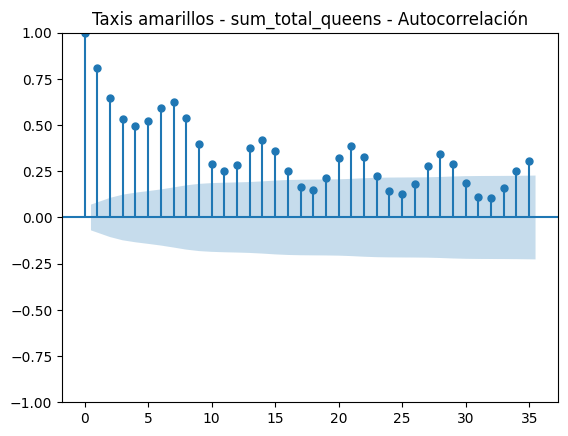

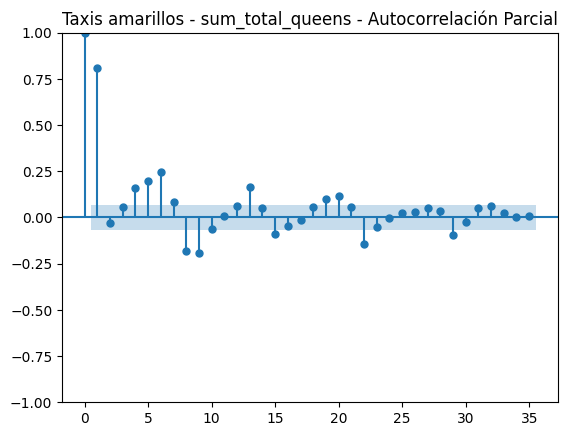

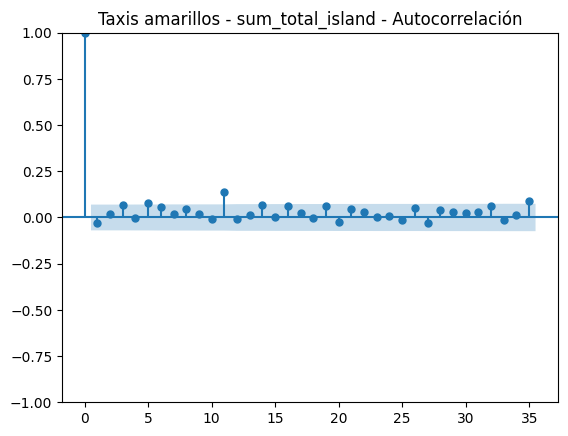

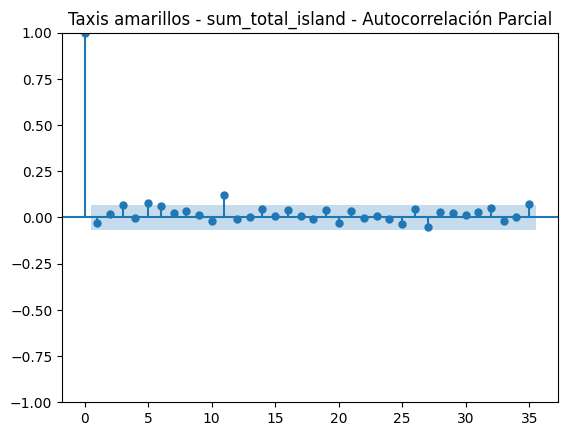

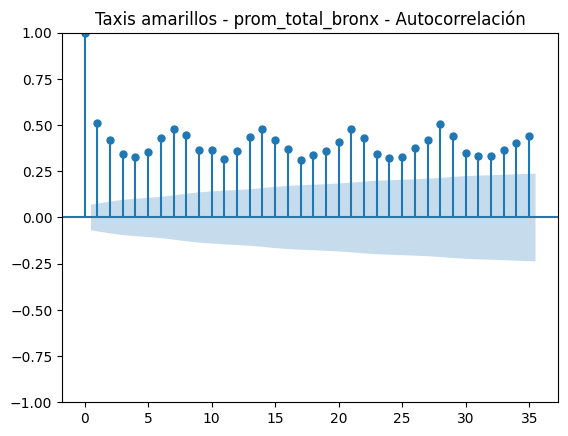

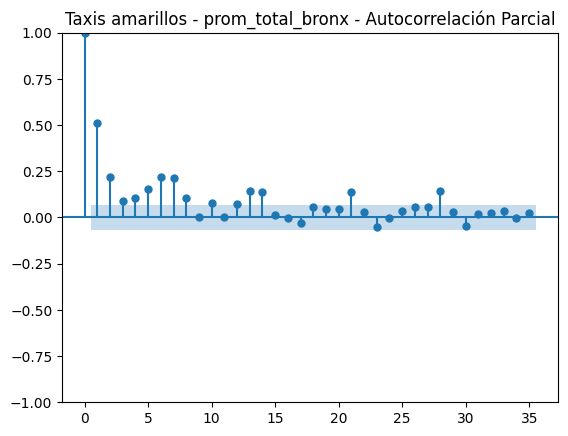

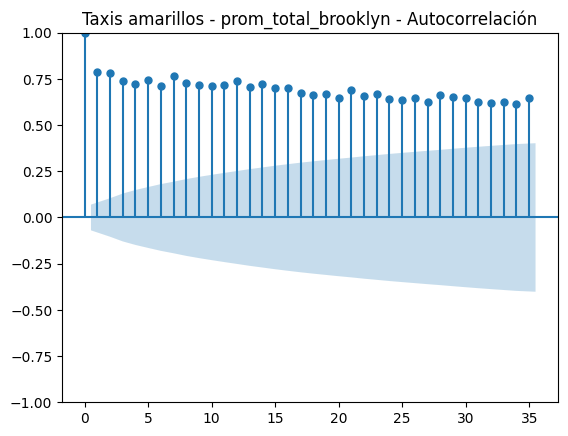

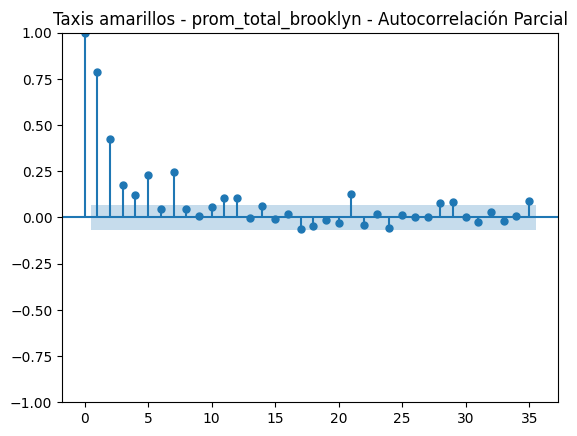

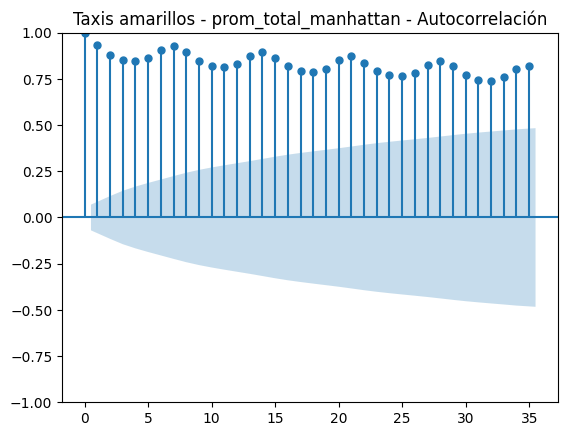

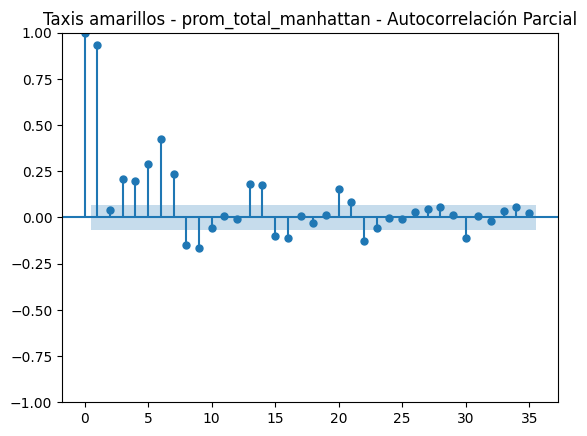

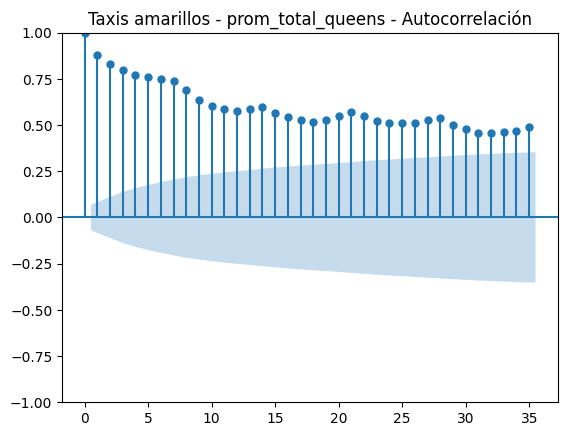

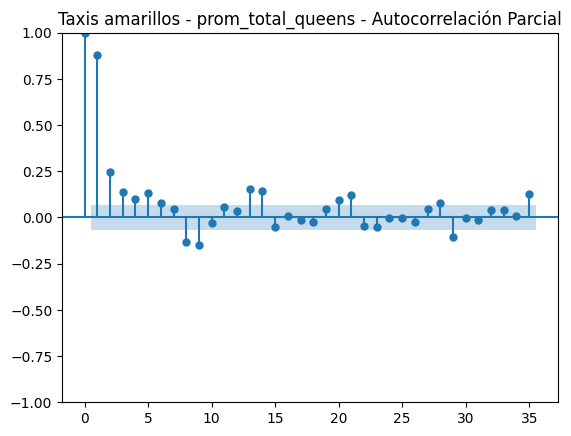

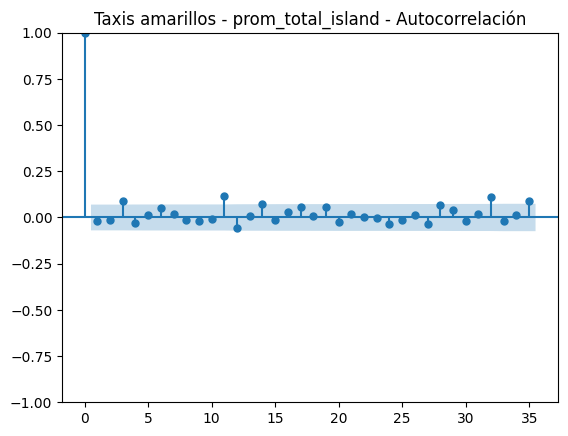

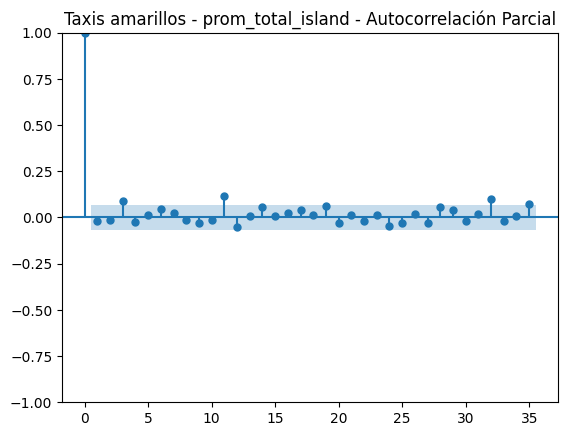

In [4]:
import sklearn as skl
import skforecast as skf
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries, backtesting_forecaster_multiseries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for col in green_df_pivot.columns:
    plot_acf(green_df_pivot[col], lags=7*5, title=f"Taxis amarillos - {col} - Autocorrelación")
    plot_pacf(green_df_pivot[col], lags=7*5, title=f"Taxis amarillos - {col} - Autocorrelación Parcial")

## Entrenamiento del modelo

<p>Como medida del rendimiento del modelo, se utilizará el coeficiente U de Theil, que permite dar una medida acotada del rendimiento del modelo.

In [6]:
def calcular_u1(y_true, y_pred):
    size = len(y_true)
    u = np.sqrt(np.sum(np.square(y_true-y_pred))/size)
    u /= np.sum(np.sqrt(np.sum(np.square(y_true))/size)+np.sqrt(np.sum(np.square(y_pred))/size))
    return u

In [7]:
train_size = len(green_df_pivot[green_df_pivot.index < date(year=2024, month=1, day=1)])
train_size

730

In [8]:
green_df_pivot.index = pd.to_datetime(green_df_pivot.index)

<p>A continuación se muestra la busqueda en grid, con los parámetros indicados. Los resultados obtenidos son:</p>

- Para cantidad de viajes: 14 lags, 20 estimadores, profundidad máxima de 8.
- Para suma de distancia: 14 lags, 10 estimadores, profundidad máxima de 12.
- Para suma de total: 7 lags, 5 estimadores, profundidad máxima de 10.
- Para promedio de total: 7 lags, 100 estimadores, profundidad máxima de 15.

In [9]:
cols = list(green_df_pivot.columns)

green_forecaster = ForecasterAutoregMultiSeries(
    regressor=RandomForestRegressor(
        max_depth=5,
        n_estimators=50,
        random_state=42
    ),
    lags=7,
    transformer_series=StandardScaler()
)

lags_grid = [5, 7, 8, 9, 11, 14]
param_grid = {
    'n_estimators': [5, 10, 20, 50, 100],
    'max_depth': list(range(4, 16))
}

green_forecasters = {}
green_grids = {}
for col in ["cant_registros", "sum_distancia", "sum_total", "prom_total"]:
    cols = [x for x in list(green_df_pivot.columns) if col in x]

    green_grid = grid_search_forecaster_multiseries(
        forecaster=green_forecaster,
        series=green_df_pivot.reset_index(),
        param_grid=param_grid,
        lags_grid=lags_grid,
        levels=cols,
        steps=10,
        metric=calcular_u1,
        initial_train_size=train_size,
        refit=True,
        fixed_train_size=True,
        return_best=True,
        verbose=False,
        show_progress=True
    )
    
    green_grids[col] = green_grid
    green_forecasters[col] = green_forecaster

green_grids

360 models compared for 5 level(s). Number of iterations: 360.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/60 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'max_depth': 8, 'n_estimators': 20}
  Backtesting metric: 0.18997986778738324
  Levels: ['cant_registros_bronx', 'cant_registros_brooklyn', 'cant_registros_manhattan', 'cant_registros_queens', 'cant_registros_island']

360 models compared for 5 level(s). Number of iterations: 360.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/60 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'max_depth': 12, 'n_estimators': 10}
  Backtesting metric: 0.22593681776465946
  Levels: ['sum_distancia_bronx', 'sum_distancia_brooklyn', 'sum_distancia_manhattan', 'sum_distancia_queens', 'sum_distancia_island']

360 models compared for 5 level(s). Number of iterations: 360.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/60 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 10, 'n_estimators': 5}
  Backtesting metric: 0.18721259985754388
  Levels: ['sum_total_bronx', 'sum_total_brooklyn', 'sum_total_manhattan', 'sum_total_queens', 'sum_total_island']

360 models compared for 5 level(s). Number of iterations: 360.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/60 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 15, 'n_estimators': 100}
  Backtesting metric: 0.14972779265089067
  Levels: ['prom_total_bronx', 'prom_total_brooklyn', 'prom_total_manhattan', 'prom_total_queens', 'prom_total_island']



{'cant_registros':                                                 levels  \
 322  [cant_registros_bronx, cant_registros_brooklyn...   
 342  [cant_registros_bronx, cant_registros_brooklyn...   
 316  [cant_registros_bronx, cant_registros_brooklyn...   
 324  [cant_registros_bronx, cant_registros_brooklyn...   
 327  [cant_registros_bronx, cant_registros_brooklyn...   
 ..                                                 ...   
 50   [cant_registros_bronx, cant_registros_brooklyn...   
 10   [cant_registros_bronx, cant_registros_brooklyn...   
 41   [cant_registros_bronx, cant_registros_brooklyn...   
 54   [cant_registros_bronx, cant_registros_brooklyn...   
 56   [cant_registros_bronx, cant_registros_brooklyn...   
 
                                                 lags  \
 322  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
 342  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
 316  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
 324  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12

<p>A continuación se entrenan modelos con los parámetros encontrados, y se realizan las predicciones.

#### Modelo para cantidad de registros

In [10]:
green_grids["cant_registros"]

,levels,lags,lags_label,params,calcular_u1,max_depth,n_estimators
322,"[cant_registros_bronx, cant_registros_brooklyn...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 8, 'n_estimators': 20}",0.189980,8,20
342,"[cant_registros_bronx, cant_registros_brooklyn...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 12, 'n_estimators': 20}",0.189994,12,20
316,"[cant_registros_bronx, cant_registros_brooklyn...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 7, 'n_estimators': 10}",0.190091,7,10
324,"[cant_registros_bronx, cant_registros_brooklyn...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 8, 'n_estimators': 100}",0.190123,8,100
327,"[cant_registros_bronx, cant_registros_brooklyn...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 9, 'n_estimators': 20}",0.190374,9,20
...,...,...,...,...,...,...,...
50,"[cant_registros_bronx, cant_registros_brooklyn...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 14, 'n_estimators': 5}",0.235619,14,5
10,"[cant_registros_bronx, cant_registros_brooklyn...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 6, 'n_estimators': 5}",0.235634,6,5
41,"[cant_registros_bronx, cant_registros_brooklyn...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 12, 'n_estimators': 10}",0.236675,12,10
54,"[cant_registros_bronx, cant_registros_brooklyn...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 14, 'n_estimators': 100}",0.236956,14,100


In [48]:
green_forecaster_cant = ForecasterAutoregMultiSeries(
    regressor=RandomForestRegressor(
        max_depth=8,
        n_estimators=20,
        random_state=42
    ),
    lags=14,
    transformer_series=StandardScaler()
)

cols = [col for col in green_df_pivot.columns if "cant_registros" in col]
green_metrics, green_predictions = backtesting_forecaster_multiseries(
    forecaster=green_forecaster_cant,
    series=green_df_pivot.reset_index(),
    levels=cols,
    initial_train_size=train_size,
    steps=10,
    metric=["mean_squared_error", "mean_absolute_error", calcular_u1],
    refit=True,
    fixed_train_size=True,
    verbose=False,
    show_progress=True
)

green_metrics

  0%|          | 0/6 [00:00<?, ?it/s]

,levels,mean_squared_error,mean_absolute_error,calcular_u1
0,cant_registros_bronx,91.151962,7.509793,0.162986
1,cant_registros_brooklyn,1464.122116,30.445630,0.073146
2,cant_registros_manhattan,25012.804956,116.769117,0.072957
3,cant_registros_queens,4163.636143,49.623594,0.067436
4,cant_registros_island,0.133018,0.337252,0.573374


In [12]:
green_predictions

,cant_registros_bronx,cant_registros_brooklyn,cant_registros_manhattan,cant_registros_queens,cant_registros_island
730,32.202524,298.941889,936.345052,438.878367,0.220563
731,41.170851,294.996526,992.076212,488.354564,0.239991
732,34.874777,298.092848,1069.036673,517.978516,0.321719
733,45.642299,273.103880,1092.569582,550.405623,0.239842
734,46.915708,297.683485,1143.430998,572.318871,0.239991
735,32.213855,269.648646,768.211365,436.635834,0.277342
736,23.989725,232.086979,805.036140,406.603480,0.239842
737,30.127183,285.381050,890.980233,430.945077,0.276565
738,36.708533,282.497629,985.491187,478.420116,0.295595
739,37.736622,289.412212,1040.663009,511.480938,0.295595


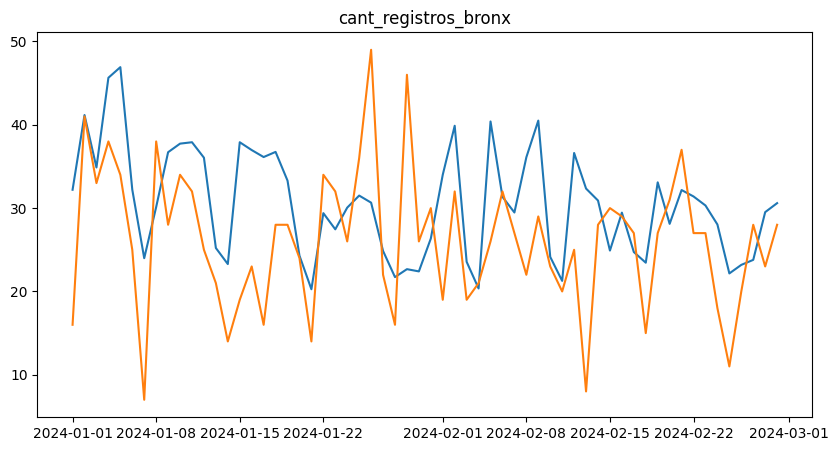

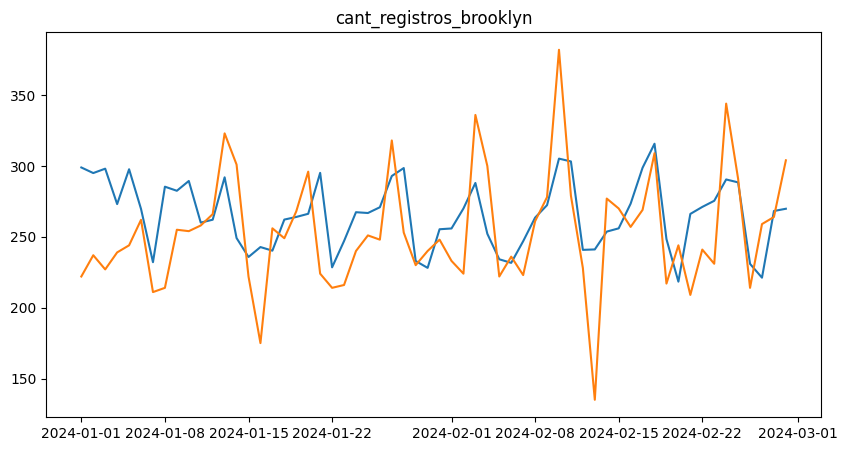

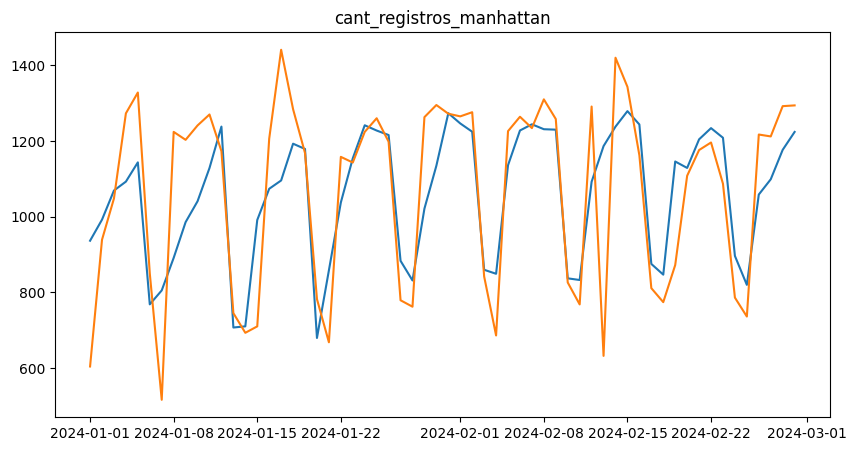

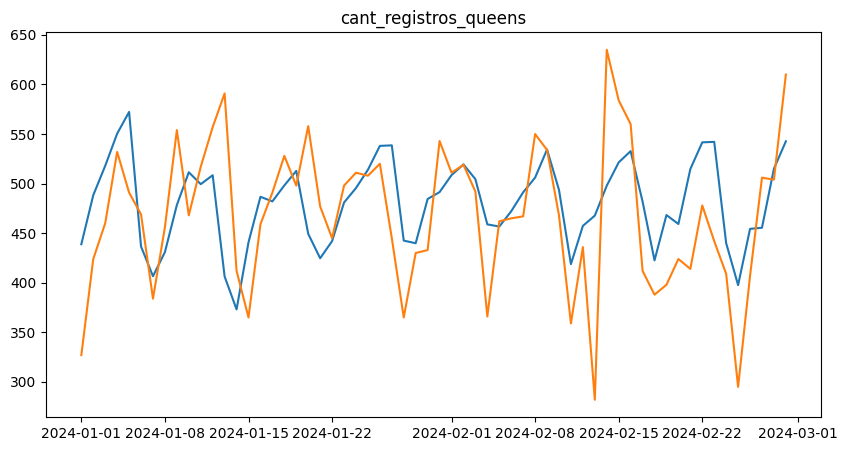

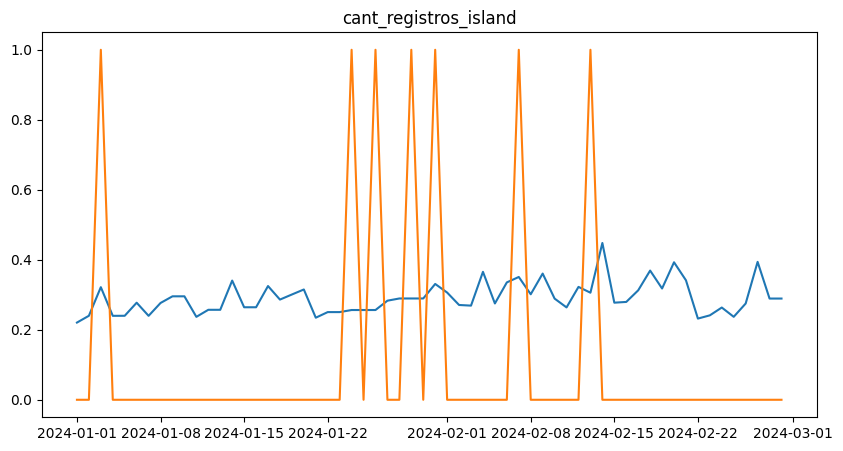

In [28]:
for col in green_predictions.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(green_df_pivot[train_size:].index, green_predictions[col])
    plt.plot(green_df_pivot[train_size:].index, green_df_pivot[train_size:][col])
    plt.title(col)
    plt.show()

In [49]:
steps=31
green_forecaster_cant.fit(series=green_df_pivot[cols])
green_preds_mar_cant = green_forecaster_cant.predict(steps=steps)
green_preds_mar_cant

,cant_registros_bronx,cant_registros_brooklyn,cant_registros_island,cant_registros_manhattan,cant_registros_queens
790,29.775788,268.828251,0.169482,1197.386966,559.052104
791,30.237888,308.465514,0.169482,857.231492,400.007179
792,19.050332,303.562194,0.169482,846.656007,392.129453
793,32.574202,227.804304,0.169482,1156.310007,413.402288
794,30.207396,252.804010,0.169482,1188.778781,484.978632
795,30.616379,249.068229,0.169482,1220.145916,508.201402
796,30.435182,275.967995,0.169929,1245.397850,538.629392
797,29.776780,253.755397,0.183929,1015.352907,526.184801
798,23.796611,286.106325,0.183929,822.735893,408.564402
799,18.995781,294.743924,0.183929,832.245213,398.719518


In [52]:
with open("green_taxis_cant.pkl", "wb") as model:
    pickle.dump(green_forecaster_cant, model)

#### Modelo para suma de distancia recorrida

In [13]:
green_grids["sum_distancia"]

,levels,lags,lags_label,params,calcular_u1,max_depth,n_estimators
341,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 12, 'n_estimators': 10}",0.225937,12,10
342,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 12, 'n_estimators': 20}",0.226095,12,20
357,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 15, 'n_estimators': 20}",0.226499,15,20
347,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 13, 'n_estimators': 20}",0.226762,13,20
337,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 11, 'n_estimators': 20}",0.227170,11,20
...,...,...,...,...,...,...,...
11,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 6, 'n_estimators': 10}",0.291359,6,10
10,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 6, 'n_estimators': 5}",0.291936,6,5
25,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 9, 'n_estimators': 5}",0.293550,9,5
15,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 7, 'n_estimators': 5}",0.293974,7,5


In [53]:
green_forecaster_dist = ForecasterAutoregMultiSeries(
    regressor=RandomForestRegressor(
        max_depth=12,
        n_estimators=10,
        random_state=42
    ),
    lags=14,
    transformer_series=StandardScaler()
)

cols = [col for col in green_df_pivot.columns if "sum_distancia" in col]
green_metrics, green_predictions = backtesting_forecaster_multiseries(
    forecaster=green_forecaster_dist,
    series=green_df_pivot.reset_index(),
    levels=cols,
    initial_train_size=train_size,
    steps=10,
    metric=["mean_squared_error", "mean_absolute_error", calcular_u1],
    refit=True,
    fixed_train_size=True,
    verbose=False,
    show_progress=True
)

green_metrics

  0%|          | 0/6 [00:00<?, ?it/s]

,levels,mean_squared_error,mean_absolute_error,calcular_u1
0,sum_distancia_bronx,1028.662766,26.825401,0.196872
1,sum_distancia_brooklyn,23752.395115,120.231768,0.094331
2,sum_distancia_manhattan,164462.925316,289.170822,0.078100
3,sum_distancia_queens,28660.510475,132.507708,0.064614
4,sum_distancia_island,12.315245,1.802478,0.695767


In [17]:
green_predictions

,sum_distancia_bronx,sum_distancia_brooklyn,sum_distancia_manhattan,sum_distancia_queens,sum_distancia_island
730,80.203934,978.592454,2444.332075,1386.767145,1.140466
731,91.259694,897.178144,2374.598650,1513.400066,1.001928
732,118.575114,973.477849,2356.973224,1479.437442,2.941048
733,118.666394,963.843979,1899.756913,1273.127065,1.746526
734,107.362095,1141.992914,2949.727646,1421.112916,0.868245
735,88.002590,955.400643,2083.227361,1281.900131,1.245875
736,72.749270,743.716609,2080.121561,1144.254816,1.331173
737,78.676429,852.795226,2270.931102,1240.907548,1.113160
738,92.532242,855.700897,2394.679849,1409.734563,1.208651
739,105.403694,956.976236,2496.536108,1456.063849,1.991315


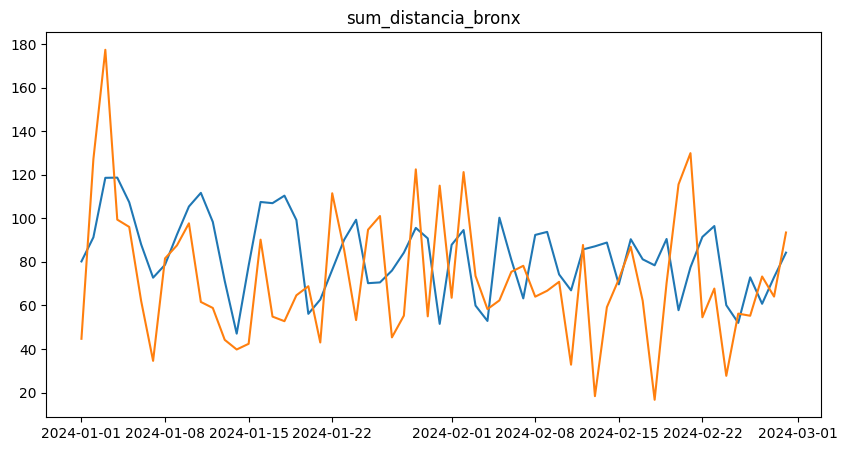

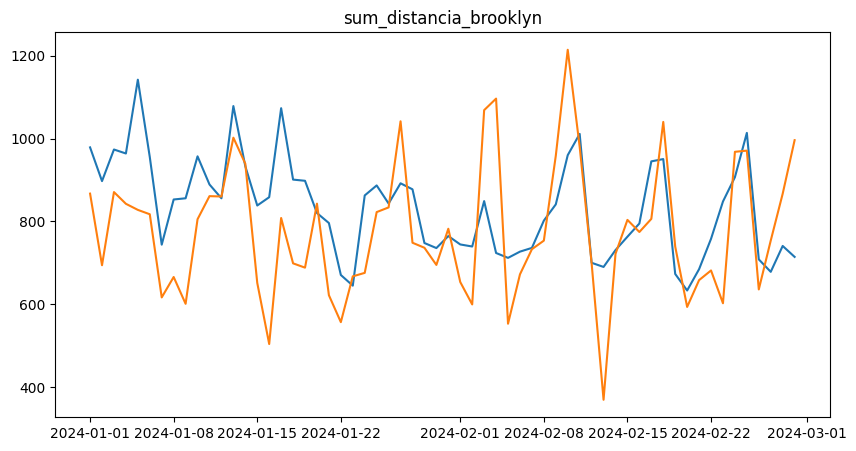

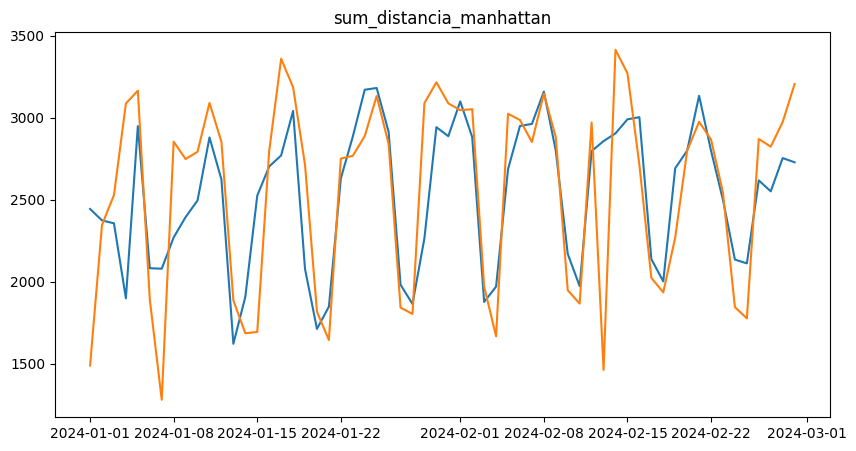

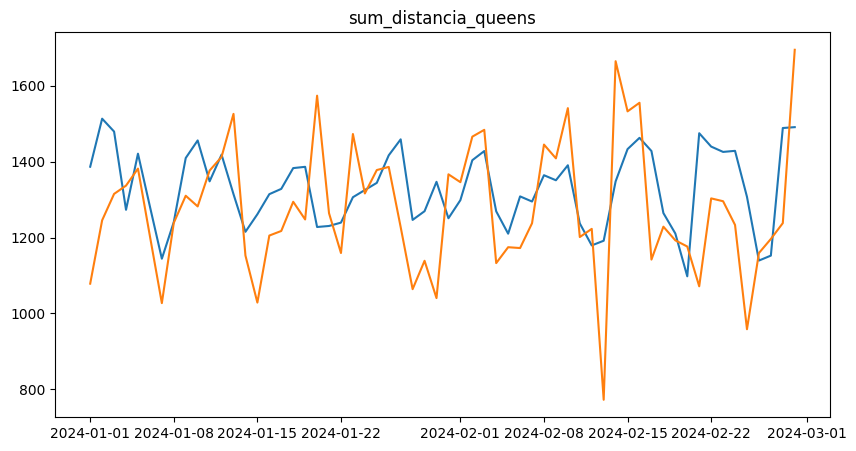

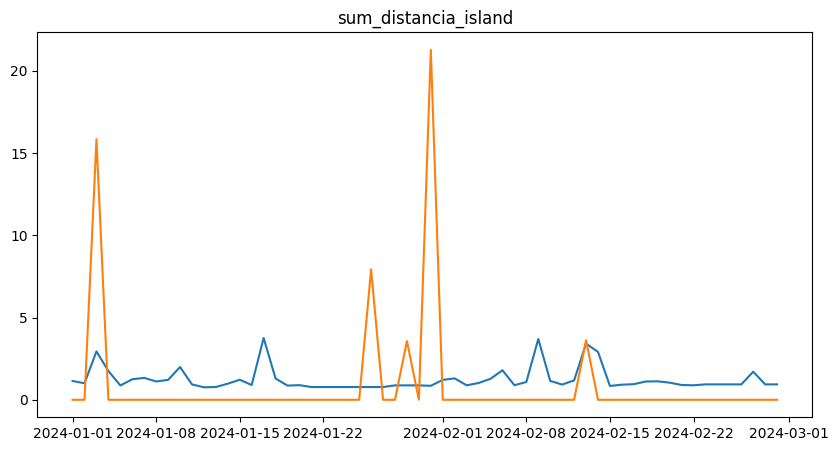

In [30]:
for col in green_predictions.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(green_df_pivot[train_size:].index, green_predictions[col])
    plt.plot(green_df_pivot[train_size:].index, green_df_pivot[train_size:][col])
    plt.title(col)
    plt.show()

In [54]:
green_forecaster_dist.fit(series=green_df_pivot[cols])
green_preds_mar_dist = green_forecaster_dist.predict(steps=steps)
green_preds_mar_dist

,sum_distancia_bronx,sum_distancia_brooklyn,sum_distancia_island,sum_distancia_manhattan,sum_distancia_queens
790,70.307830,857.254138,0.970909,2501.098437,1518.217100
791,50.686376,913.662561,0.970909,2059.612960,1190.181281
792,59.352560,885.851975,0.970909,1946.080137,1213.951411
793,71.873796,722.499847,0.970909,2686.455934,1233.737239
794,82.772653,698.983060,0.711645,2913.480062,1232.170201
795,119.007862,641.452622,0.711645,3054.552240,1132.263911
796,95.993093,953.220397,0.654376,3018.536038,1294.553633
797,50.292495,776.559551,0.654376,2523.037328,1293.317396
798,61.511130,826.764674,0.654376,1939.000941,1094.551788
799,70.186326,839.679560,3.235922,1886.465173,1192.087552


In [55]:
with open("green_taxis_dist.pkl", "wb") as model:
    pickle.dump(green_forecaster_dist, model)

#### Modelo para suma de costo total

In [18]:
green_grids["sum_total"]

,levels,lags,lags_label,params,calcular_u1,max_depth,n_estimators
90,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 10, 'n_estimators': 5}",0.187213,10,5
85,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 9, 'n_estimators': 5}",0.187559,9,5
95,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 11, 'n_estimators': 5}",0.188770,11,5
100,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 12, 'n_estimators': 5}",0.191073,12,5
107,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 13, 'n_estimators': 20}",0.191928,13,20
...,...,...,...,...,...,...,...
25,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 9, 'n_estimators': 5}",0.239548,9,5
30,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 5}",0.239712,10,5
55,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 15, 'n_estimators': 5}",0.244044,15,5
45,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 13, 'n_estimators': 5}",0.249839,13,5


In [56]:
green_forecaster_total = ForecasterAutoregMultiSeries(
    regressor=RandomForestRegressor(
        max_depth=10,
        n_estimators=5,
        random_state=42
    ),
    lags=7,
    transformer_series=StandardScaler()
)

cols = [col for col in green_df_pivot.columns if "sum_total" in col]
green_metrics, green_predictions = backtesting_forecaster_multiseries(
    forecaster=green_forecaster_total,
    series=green_df_pivot.reset_index(),
    levels=cols,
    initial_train_size=train_size,
    steps=10,
    metric=["mean_squared_error", "mean_absolute_error", calcular_u1],
    refit=True,
    fixed_train_size=True,
    verbose=False,
    show_progress=True
)

green_metrics

  0%|          | 0/6 [00:00<?, ?it/s]

,levels,mean_squared_error,mean_absolute_error,calcular_u1
0,sum_total_bronx,7.933271e+04,227.884684,0.180008
1,sum_total_brooklyn,1.399703e+06,984.653071,0.085652
2,sum_total_manhattan,1.779497e+07,3317.865000,0.092198
3,sum_total_queens,2.216915e+06,1116.793432,0.069906
4,sum_total_island,3.019973e+02,14.161185,0.508297


In [23]:
green_predictions

,sum_total_bronx,sum_total_brooklyn,sum_total_manhattan,sum_total_queens,sum_total_island
730,647.783565,6395.971268,16493.984236,7050.199295,8.256807
731,780.687761,5601.067015,19018.979160,10011.598104,8.256807
732,1004.792458,7809.606433,18411.102062,11352.624464,8.256807
733,968.507171,7856.997115,19095.796466,11758.234041,8.608403
734,1026.968044,7930.024604,18734.261805,11251.283837,9.497004
735,780.670361,8789.590783,14872.305509,11585.689687,9.497004
736,717.214876,7764.372384,14989.605935,10048.974199,11.402209
737,833.528708,6394.793660,17034.449263,8665.270945,11.402209
738,899.865261,6145.028307,18512.312323,9677.785404,11.402209
739,953.881049,7514.135118,18512.312323,10158.717570,11.402209


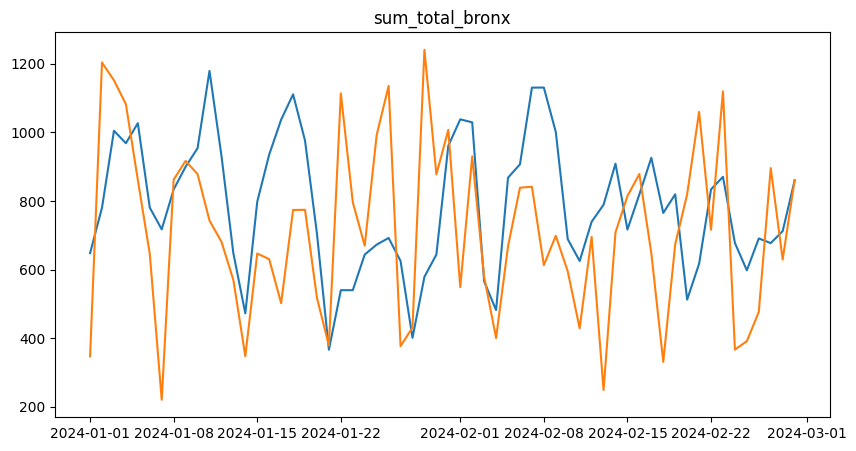

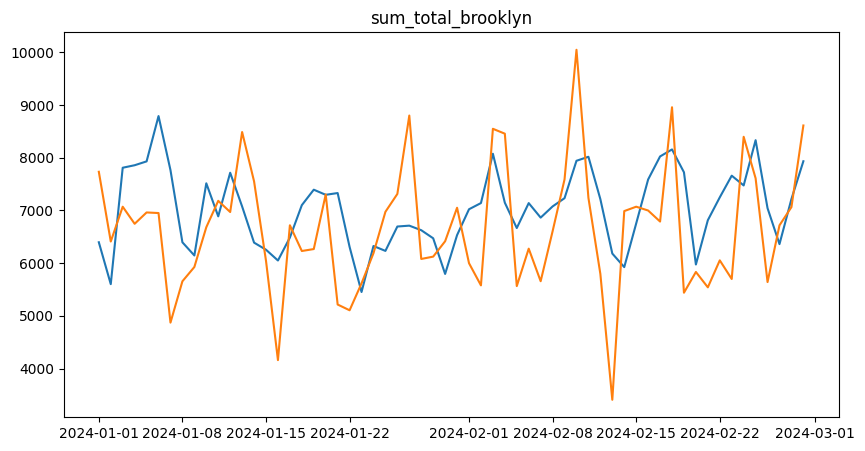

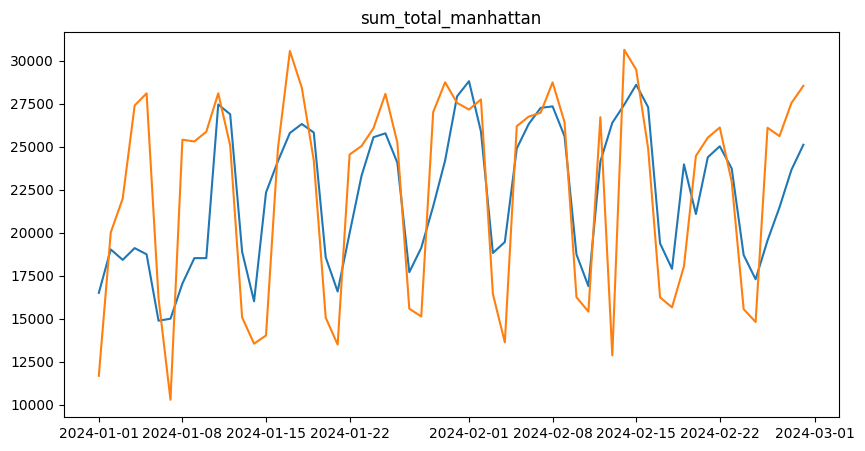

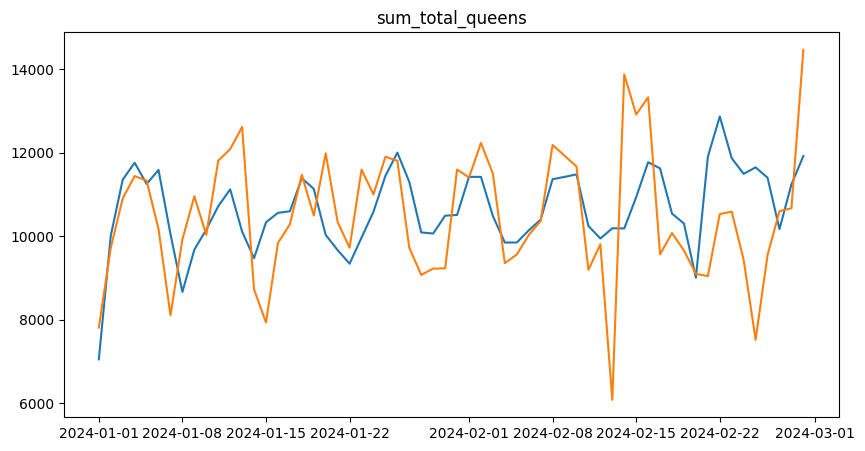

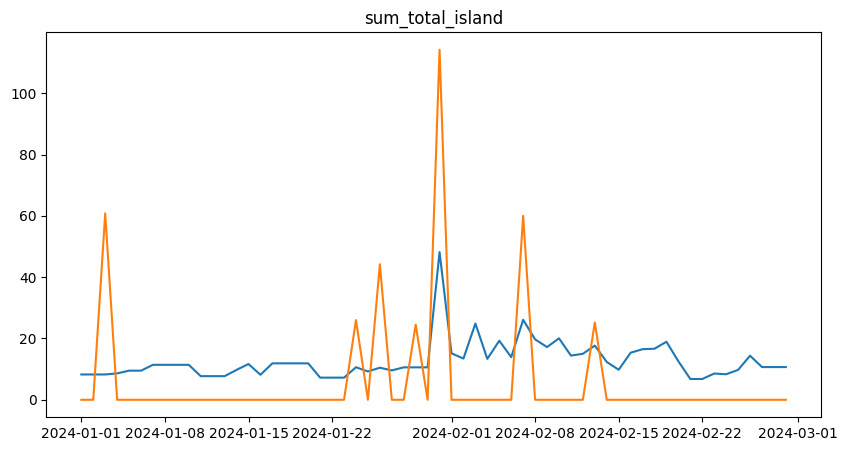

In [32]:
for col in green_predictions.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(green_df_pivot[train_size:].index, green_predictions[col])
    plt.plot(green_df_pivot[train_size:].index, green_df_pivot[train_size:][col])
    plt.title(col)
    plt.show()

In [57]:
green_forecaster_total.fit(series=green_df_pivot[cols])
green_preds_mar_total = green_forecaster_total.predict(steps=steps)
green_preds_mar_total

,sum_total_bronx,sum_total_brooklyn,sum_total_island,sum_total_manhattan,sum_total_queens
790,922.719409,7332.869285,7.346172,25398.254920,13786.379568
791,649.757796,7895.871987,7.346172,18388.465749,9595.944130
792,298.358240,7698.693454,7.346172,17013.031330,8846.189445
793,790.953344,6439.284899,7.346172,23056.386143,10310.207794
794,701.892731,6991.342406,7.346172,24674.670213,11575.396903
795,966.693203,7339.084890,7.346172,26505.190404,12469.894256
796,826.652734,7491.700968,7.346172,27732.425034,13852.854625
797,873.955518,7496.214229,7.346172,27023.455467,13271.186152
798,680.856617,7905.782840,7.346172,19239.483121,7738.581062
799,507.657571,7548.049746,7.346172,17407.760023,9512.579355


In [58]:
with open("green_taxis_total.pkl", "wb") as model:
    pickle.dump(green_forecaster_total, model)

#### Modelo para promedio del costo total

In [21]:
green_grids["prom_total"]

,levels,lags,lags_label,params,calcular_u1,max_depth,n_estimators
119,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 15, 'n_estimators': 100}",0.149728,15,100
117,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 15, 'n_estimators': 20}",0.151443,15,20
100,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 12, 'n_estimators': 5}",0.151453,12,5
235,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'max_depth': 15, 'n_estimators': 5}",0.152079,15,5
114,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 14, 'n_estimators': 100}",0.152455,14,100
...,...,...,...,...,...,...,...
5,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 5}",0.174849,5,5
3,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 4, 'n_estimators': 50}",0.175214,4,50
1,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 4, 'n_estimators': 10}",0.175221,4,10
4,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 4, 'n_estimators': 100}",0.175398,4,100


In [59]:
green_forecaster_prom = ForecasterAutoregMultiSeries(
    regressor=RandomForestRegressor(
        max_depth=100,
        n_estimators=15,
        random_state=42
    ),
    lags=7,
    transformer_series=StandardScaler()
)

cols = [col for col in green_df_pivot.columns if "prom_total" in col]
green_metrics, green_predictions = backtesting_forecaster_multiseries(
    forecaster=green_forecaster_prom,
    series=green_df_pivot.reset_index(),
    levels=cols,
    initial_train_size=train_size,
    steps=10,
    metric=["mean_squared_error", "mean_absolute_error", calcular_u1],
    refit=True,
    fixed_train_size=True,
    verbose=False,
    show_progress=True
)

green_metrics

  0%|          | 0/6 [00:00<?, ?it/s]

,levels,mean_squared_error,mean_absolute_error,calcular_u1
0,prom_total_bronx,19.977912,3.540593,0.082453
1,prom_total_brooklyn,5.468270,1.877234,0.043890
2,prom_total_manhattan,0.618035,0.647955,0.018883
3,prom_total_queens,2.263993,1.170468,0.033242
4,prom_total_island,369.583551,11.951522,0.622113


In [60]:
green_predictions

,prom_total_bronx,prom_total_brooklyn,prom_total_manhattan,prom_total_queens,prom_total_island
730,24.462118,29.772003,19.298964,25.289026,6.078778e+00
731,25.335313,27.909739,19.863570,24.018808,1.285427e+00
732,27.832446,28.303887,20.676329,23.446169,1.617501e+00
733,28.064735,29.010439,21.233940,23.585814,6.496254e+00
734,29.488246,28.283604,20.397977,23.758297,2.137506e+01
735,28.159970,30.402260,18.315219,24.094950,1.107252e+01
736,24.650600,29.731996,18.865780,24.203933,1.028953e+01
737,25.324998,29.370930,19.072303,24.637955,2.299327e+01
738,26.867684,28.435881,19.977509,24.081880,1.480218e+01
739,27.868379,28.819523,19.453512,23.630667,7.230139e+00


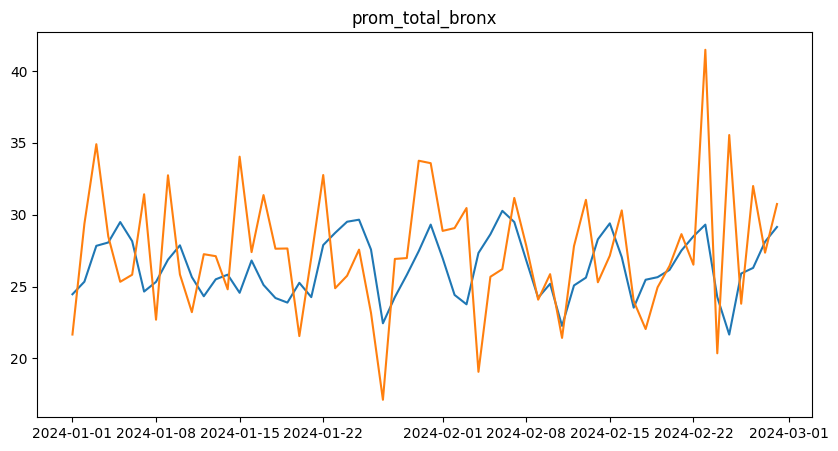

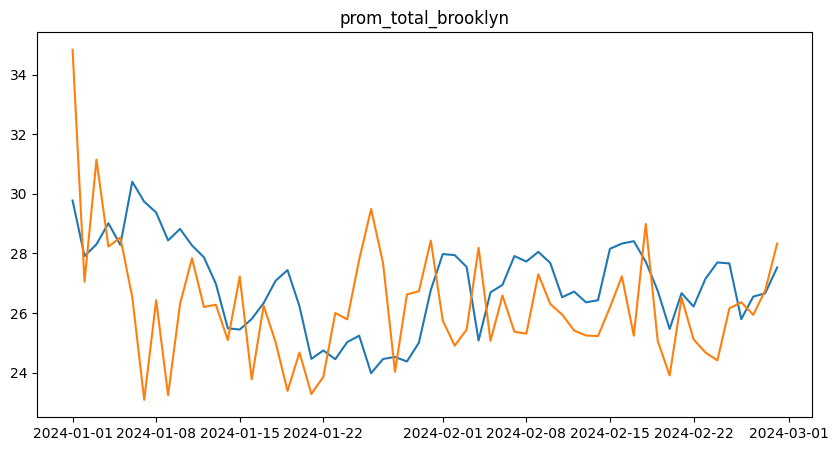

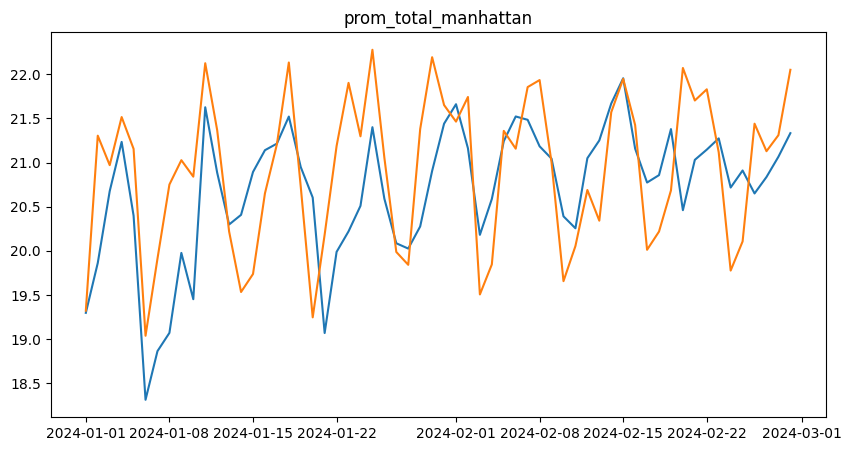

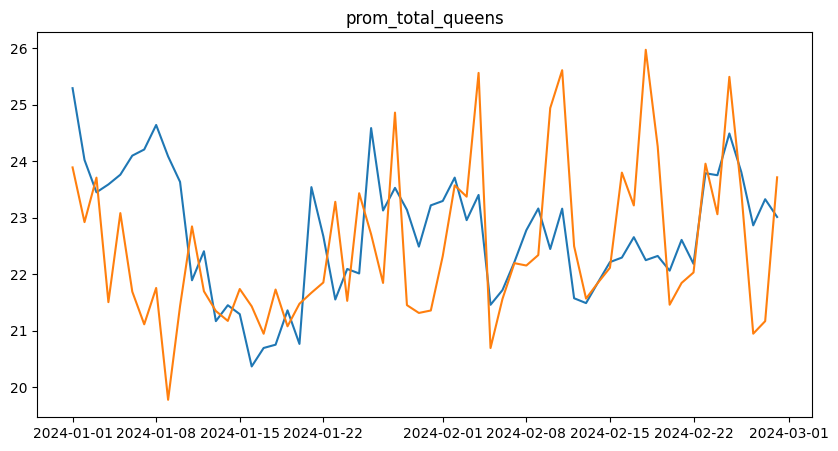

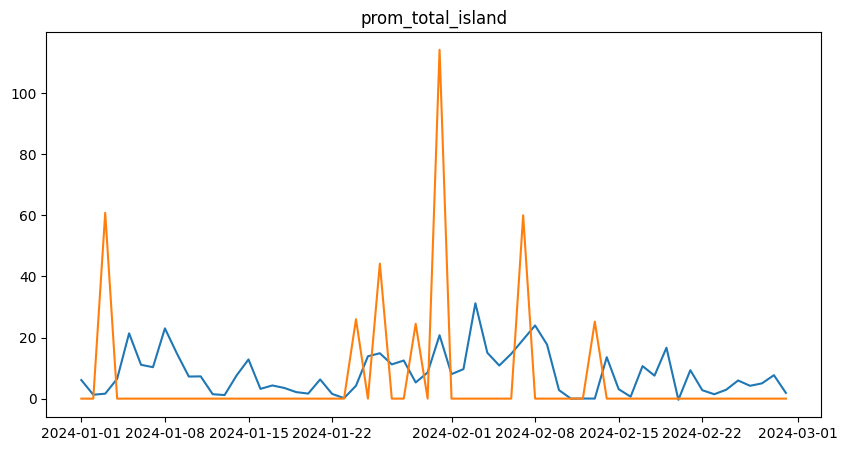

In [61]:
for col in green_predictions.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(green_df_pivot[train_size:].index, green_predictions[col])
    plt.plot(green_df_pivot[train_size:].index, green_df_pivot[train_size:][col])
    plt.title(col)
    plt.show()

In [62]:
green_forecaster_prom.fit(series=green_df_pivot[cols])
green_preds_mar_prom = green_forecaster_prom.predict(steps=steps)
green_preds_mar_prom

,prom_total_bronx,prom_total_brooklyn,prom_total_island,prom_total_manhattan,prom_total_queens
790,29.401685,27.634775,5.166129,21.576653,22.688658
791,27.265266,26.369189,5.114878,20.609188,23.492821
792,24.930675,27.376133,6.444685,20.792511,24.633133
793,26.727294,27.385992,3.598749,21.076830,23.141411
794,30.523681,28.105852,9.415085,21.308907,23.107216
795,29.125429,28.959792,3.742106,21.583174,22.655346
796,29.261810,27.937815,2.716311,21.420196,23.529569
797,29.795771,28.060633,8.600521,21.583243,23.468287
798,25.825937,27.234843,6.017036,21.416623,23.468379
799,28.012923,27.915962,7.723847,21.252129,23.938869


In [63]:
with open("green_taxis_prom.pkl", "wb") as model:
    pickle.dump(green_forecaster_prom, model)

# Resumen para el mes de marzo

<p>Para el resumen del mes, se utilizan las predicciones generadas por todos los modelos, agregándolas según corresponda, luego se guardan como un dataframe y se exportan a CSV.

In [67]:
barrios = ["Bronx", "Brooklyn", "Staten Island", "Manhattan", "Queens"]
cants = green_preds_mar_cant.sum().round().astype(int)
cants.index = barrios
cants.name = "cant_registros"
cants

Bronx              866
Brooklyn          8433
Staten Island        6
Manhattan        32843
Queens           14373
Name: cant_registros, dtype: int32

In [68]:
dists = green_preds_mar_dist.sum()
dists.index = barrios
dists.name = "sum_distancia"
dists

Bronx             2246.236707
Brooklyn         25391.172930
Staten Island       44.000423
Manhattan        78859.587907
Queens           38453.515108
Name: sum_distancia, dtype: float64

In [69]:
totals = green_preds_mar_total.sum()
totals.index = barrios
totals.name = "sum_total"
totals

Bronx             28038.108529
Brooklyn         238186.177021
Staten Island       227.731319
Manhattan        728465.824891
Queens           357662.708235
Name: sum_total, dtype: float64

In [70]:
proms = green_preds_mar_prom.mean()
proms.index = barrios
proms.name = "prom_total"
proms

Bronx            28.311413
Brooklyn         28.072557
Staten Island    14.068850
Manhattan        21.255821
Queens           23.643650
Name: prom_total, dtype: float64

In [74]:
marzo = pd.DataFrame([cants, dists, totals, proms]).transpose()
marzo.index.name = "barrio_abordaje"
marzo.reset_index(inplace=True)
marzo["mes"] = date(year=2024, month=3, day=1)
marzo

,barrio_abordaje,cant_registros,sum_distancia,sum_total,prom_total,mes
0,Bronx,866.0,2246.236707,28038.108529,28.311413,2024-03-01
1,Brooklyn,8433.0,25391.172930,238186.177021,28.072557,2024-03-01
2,Staten Island,6.0,44.000423,227.731319,14.068850,2024-03-01
3,Manhattan,32843.0,78859.587907,728465.824891,21.255821,2024-03-01
4,Queens,14373.0,38453.515108,357662.708235,23.643650,2024-03-01


In [77]:
marzo.to_csv("predicciones_marzo_green.csv", index=False)